In [34]:
import numpy as np
import glob
import tensorflow as tf
from tensorflow.keras import Model, Input, regularizers, initializers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
from sklearn.utils import shuffle
import PIL.ImageOps

# tf.debugging.set_log_device_placement(False)


In [35]:
lr_dense_images = glob.glob('/home/vr-lab/Asish/8th Sem Radar Project/LR-HR_Simulation/dense/HR/*.jpg') #returns path of images
lr_dense_images.sort()
print(len(lr_dense_images))
lr_sparse_images = glob.glob('/home/vr-lab/Asish/8th Sem Radar Project/LR-HR_Simulation/sparse/HR/*.jpg') #returns path of images
lr_sparse_images.sort()

3000


In [36]:
hr_dense_images = glob.glob('/home/vr-lab/Asish/8th Sem Radar Project/LR-HR_Simulation/dense/LR/*.jpg') #returns path of images
hr_dense_images.sort()
print(len(hr_dense_images))
hr_sparse_images = glob.glob('/home/vr-lab/Asish/8th Sem Radar Project/LR-HR_Simulation/sparse/LR/*.jpg') #returns path of images
hr_sparse_images.sort()

3000


In [37]:
from tqdm import tqdm
from multiprocessing import Pool
import random
progress = tqdm(total= len(lr_dense_images), position=0)
img_size=(128,128,1)
def read(path):
  img = image.load_img(path, color_mode='grayscale', target_size=img_size)
#   a = random.choice([0, 1])
#   if a == 0:
  img = PIL.ImageOps.invert(img)
  img = image.img_to_array(img)
  img = img/255.
  progress.update(1)
  return img

def read_wout_inv(path):
  img = image.load_img(path, color_mode='grayscale', target_size=img_size)
#   a = random.choice([0, 1])
#   if a == 0:
#   img = PIL.ImageOps.invert(img)
  img = image.img_to_array(img)
  img = img/255.
  progress.update(1)
  return img
  
p = Pool(10)

 40%|████      | 1212/3000 [00:04<00:03, 516.70it/s]

In [38]:
lr_train_img_array = p.map(read, lr_dense_images[:2200]) + p.map(read, lr_sparse_images[:2200])        # Put both sparse and dense in one variable
lr_val_img_array = p.map(read, lr_dense_images[2200:]) + p.map(read, lr_sparse_images[2200:])        # Put both sparse and dense in one variable

In [39]:
hr_train_img_array = p.map(read, hr_dense_images[:2200]) + p.map(read, hr_sparse_images[:2200])
hr_val_img_array = p.map(read, hr_dense_images[2200:]) + p.map(read, hr_sparse_images[2200:])

In [40]:
print(np.array(lr_train_img_array).shape)
print(np.array(lr_val_img_array).shape)
print(np.array(hr_train_img_array).shape)
print(np.array(hr_val_img_array).shape)

(4400, 128, 128, 1)
(1600, 128, 128, 1)
(4400, 128, 128, 1)
(1600, 128, 128, 1)


In [41]:
# Shuffle the arrays in unison for better training
lr_train, hr_train = shuffle(lr_train_img_array, hr_train_img_array, random_state=0)
lr_val, hr_val = shuffle(lr_val_img_array, hr_val_img_array, random_state=0)

In [42]:
lr_train = np.array(lr_train)
hr_train = np.array(hr_train)
lr_val = np.array(lr_val)
hr_val = np.array(hr_val)

# with tf.device('/GPU:0'):
#     lr_train = tf.convert_to_tensor(lr_train)
#     hr_train = tf.convert_to_tensor(hr_train)
#     lr_val = tf.convert_to_tensor(lr_val)
#     hr_val = tf.convert_to_tensor(hr_val)

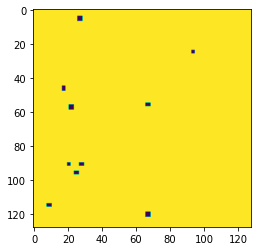

In [43]:
i=15
plt.imshow(hr_train[i])

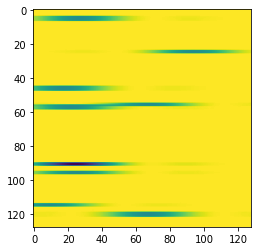

In [44]:
plt.imshow(lr_train[i])

In [56]:
# with tf.device('/GPU:0'):
Input_img = Input(shape=img_size)  

#encoding architecture
# x1 = Conv2D(64, (3, 3), activation='relu', padding='same', 
#             kernel_initializer=initializers.RandomNormal(stddev=5), bias_initializer='zeros')(Input_img)
x1 = Conv2D(64, (3, 3), activation='relu', padding='same')(Input_img)
x2 = Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
x3 = MaxPool2D(padding='same')(x2)
x4 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
x5 = Conv2D(128, (3, 3), activation='relu', padding='same')(x4)
x6 = MaxPool2D(padding='same')(x5)
x7 = Conv2D(256, (3, 3), activation='relu', padding='same')(x6)
x8 = Conv2D(256, (3, 3), activation='relu', padding='same')(x7)
x9 = MaxPool2D(padding='same')(x8)
encoded = Conv2D(512, (3, 3), activation='relu', padding='same')(x9)
#encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)

# decoding architecture
x10 = UpSampling2D()(encoded)
x11 = Conv2D(256, (3, 3), activation='relu', padding='same')(x10)
x12 = Conv2D(256, (3, 3), activation='relu', padding='same')(x11)
x13 = Add()([x8, x12])
x14 = UpSampling2D()(x13)
x15 = Conv2D(128, (3, 3), activation='relu', padding='same')(x14)
x16 = Conv2D(128, (3, 3), activation='relu', padding='same')(x15)
x17 = Add()([x5, x16])
x18 = UpSampling2D()(x17)
x19 = Conv2D(64, (3, 3), activation='relu', padding='same')(x18)
x20 = Conv2D(64, (3, 3), activation='relu', padding='same')(x19)
x21 = Add()([x2, x20])
# x3 = UpSampling2D((2, 2))(x3)
# x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
# x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
decoded = Conv2D(1, (3, 3), padding='same',activation='relu')(x21)

enc_dec = Model(Input_img, decoded)
# loss_rec = tf.reduce_mean(tf.image.ssim(truth, reconstructed, 2.0))
enc_dec.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [57]:
enc_dec.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_42 (Conv2D)              (None, 128, 128, 64) 640         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 128, 128, 64) 36928       conv2d_42[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 64, 64, 64)   0           conv2d_43[0][0]                  
____________________________________________________________________________________________

In [48]:
print("Num GPUs Available: ", tf.config.experimental.list_physical_devices('GPU'))

Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [49]:
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=50, verbose=1, mode='min')
model_checkpoint =  ModelCheckpoint('models/SR3_diff_shape_mse_loss_checkpoint.h5', save_best_only = True)

In [50]:
history = enc_dec.fit(lr_train,hr_train, 
            batch_size=32,
            epochs=75,
            validation_data=(lr_val, hr_val),
            callbacks=[early_stopper, model_checkpoint])

Epoch 1/75
138/138 [==============================] - 23s 162ms/step - loss: 3.3282 - accuracy: 0.5965 - val_loss: 0.0025 - val_accuracy: 0.9957
Epoch 2/75
138/138 [==============================] - 22s 160ms/step - loss: 0.0025 - accuracy: 0.9957 - val_loss: 0.0023 - val_accuracy: 0.9957
Epoch 3/75
138/138 [==============================] - 22s 161ms/step - loss: 0.0022 - accuracy: 0.9958 - val_loss: 0.0019 - val_accuracy: 0.9962
Epoch 4/75
138/138 [==============================] - 22s 161ms/step - loss: 0.0018 - accuracy: 0.9962 - val_loss: 0.0014 - val_accuracy: 0.9967
Epoch 5/75
138/138 [==============================] - 22s 161ms/step - loss: 0.0014 - accuracy: 0.9967 - val_loss: 0.0013 - val_accuracy: 0.9967
Epoch 6/75
138/138 [==============================] - 22s 161ms/step - loss: 0.0013 - accuracy: 0.9967 - val_loss: 0.0014 - val_accuracy: 0.9966
Epoch 7/75
138/138 [==============================] - 22s 161ms/step - loss: 0.0013 - accuracy: 0.9967 - val_loss: 9.0562e-04 - va

Epoch 55/75
138/138 [==============================] - 22s 162ms/step - loss: 2.6247e-04 - accuracy: 0.9976 - val_loss: 2.7082e-04 - val_accuracy: 0.9976
Epoch 56/75
138/138 [==============================] - 22s 162ms/step - loss: 2.4459e-04 - accuracy: 0.9977 - val_loss: 2.9416e-04 - val_accuracy: 0.9975
Epoch 57/75
138/138 [==============================] - 22s 162ms/step - loss: 2.4361e-04 - accuracy: 0.9976 - val_loss: 3.0672e-04 - val_accuracy: 0.9976
Epoch 58/75
138/138 [==============================] - 22s 162ms/step - loss: 2.1589e-04 - accuracy: 0.9976 - val_loss: 2.9714e-04 - val_accuracy: 0.9976
Epoch 59/75
138/138 [==============================] - 22s 161ms/step - loss: 2.2479e-04 - accuracy: 0.9977 - val_loss: 2.8251e-04 - val_accuracy: 0.9975
Epoch 60/75
138/138 [==============================] - 22s 161ms/step - loss: 1.9775e-04 - accuracy: 0.9977 - val_loss: 2.8244e-04 - val_accuracy: 0.9976
Epoch 61/75
138/138 [==============================] - 22s 162ms/step - loss

In [51]:
results = enc_dec.evaluate(lr_val, hr_val)
print('val_loss, val_accuracy', results)

50/50 [==============================] - 2s 46ms/step - loss: 2.6868e-04 - accuracy: 0.9976
val_loss, val_accuracy [0.00026868245913647115, 0.9975594878196716]


In [58]:
enc_dec.load_weights('models/SR3_diff_shape_mse_loss_checkpoint.h5')

In [59]:
loss, acc = enc_dec.evaluate(lr_val, hr_val, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

50/50 - 2s - loss: 2.4156e-04 - accuracy: 0.9976
Restored model, accuracy: 99.76%


In [52]:
pred = enc_dec.predict(lr_val)

In [53]:
print(pred.shape)

(1600, 128, 128, 1)


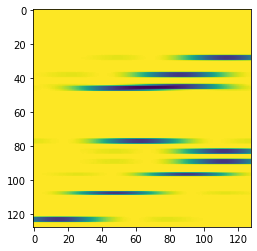

In [54]:
plt.imshow(lr_val[1])

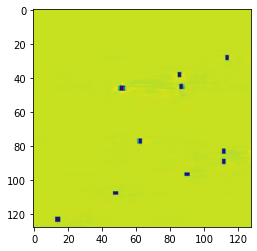

In [55]:
plt.imshow(pred[1])

In [75]:
def normalize(v):
    v_min = v.min(axis=(1, 2), keepdims=True)
    v_max = v.max(axis=(1, 2), keepdims=True)
    return (v - v_min)/(v_max - v_min)

(1, 128, 128, 1)


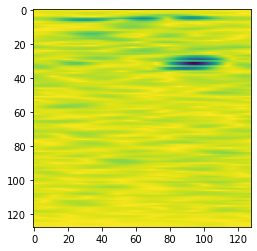

In [83]:
import os
scene = '2019_04_09_BMS1000'
seq_num = 150
img_name = os.path.join('/home/vr-lab/Asish/8th Sem Radar Project/Datasets/CRUW/TRAIN_RAD_H',scene,'RADAR_RA_H','%06d_0000.npy' % seq_num)
img = np.load(img_name)
fimg = np.sqrt(np.sum(np.square(img), axis=2,keepdims=True))
fimg = np.expand_dims(fimg, axis=0)
fimg = normalize(fimg)
fimg =1-fimg
print(fimg.shape)
# print(fimg.min())
plt.imshow(fimg[0])

(1, 128, 128, 1)


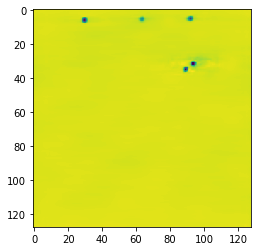

In [84]:
pred1 = enc_dec.predict(fimg)
print(pred1.shape)
plt.imshow(pred1[0])